# Vanilla Feed Forward Neural Network

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory to current notebook
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Feed Forward Neural Nets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Feed Forward Neural Nets


Here we create the vanilla feed forward neural network (*v-fnn*) for the BA-thesis.

High-level notebook structure:

1.  Import data + convert to tensorflow db + datasplits.
2.  Create baseline model.
3.  Coarse hyperparameter search (no pruning).
4.  Hyperparameter importance (fANONA).
5.  Fine hyperparameter search (with median pruning).
6.  Evaluate final model.


Most of the compute ressource is allocated to the coarse search (3), since we need

# Data Ingestion & Preprocessing Pipeline

Import data, seperate into features and labels, convert into tensorflow dataset, and split into test, validation and train data.

## Load Raw Data

Data is imported after rough data clean (see notebooks in Data folder).

In [2]:
import pandas as pd
import numpy as np

In [3]:
data_stock_returns = pd.read_parquet("../Data/handoffs/data_stock_returns_final.parquet")
data_stock_returns = data_stock_returns.sort_values('eom')

# list of independent features
list_primary_features = [
    feat for feat in data_stock_returns.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
  ]

# Create feature and labels
X = data_stock_returns[list_primary_features]
y = data_stock_returns['ret_exc_lead1m']

# tensorflow uses float32
# additional precision is not needed
X = X.to_numpy(dtype='float32')
y = y.to_numpy(dtype='float32')

## Train/Validation/Test Split & Dataset Builder

70/15/15 Train/Validation/Test. We also create a dataset builder where batch size is defined, to keep training performant.

In [4]:
n = len(data_stock_returns)
train_end = int(n * 0.70); val_end = int(n * 0.85)

# create train, test, val splits
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [5]:
def build_dataset(X, y, batch_size):
  # Create tensorflow dataset
  dataset = tf.data.Dataset.from_tensor_slices((X, y))

  # Declare batchsize in dataset constructor
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch data to improve performance
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

To limit memory and RAM usage variables that are not needed are deleted.

In [6]:
%who

X	 X_test	 X_train	 X_val	 build_dataset	 data_stock_returns	 drive	 list_primary_features	 n	 
np	 pd	 train_end	 val_end	 y	 y_test	 y_train	 y_val	 


In [7]:
del X, y, data_stock_returns, list_primary_features, train_end, val_end

# Baseline model

As recommended in the *deep learning book* a reasonable baseline model is created.

|       Parameter       |             Type            |                              Reason                              |
|:---------------------:|:---------------------------:|:----------------------------------------------------------------:|
| Architecture          | Feed forward neural network | The NN studied here                                              |
| Input                 | $X \in \mathbb{R}^{195}$    | Shape of features.                                               |
| # Hidden Layers       | 2 Dense                     | Simplicity                                                       |
| # Units               | [64,32]                     | Reduction: helps generalize.                                     |
| Activations           | [ReLu, tanh]                | ReLu: Standard. tanh: pos./neg. output.                         |
| Output Layer          | None (Linear)               | Real valued predictions.                                         |
| Loss                  | Mean Squared Error (MSE)    | Statistically best with Gaussian noise.                          |
| Optimizer             | Adam                        | Sparse gradients and adaptive learning rates: good at noisy data |
| Learning Rate         | 0.001                       | Default Adam: Stable convergence.                                |
| Batch Size            | 64                          | GPU efficiency.                                                  |
| Epochs                | 60 + early stopping         | Efficiency + does not overfit.                                   |
| Dropout               | 0.2                         | Regularization of noisy domain.                                  |
| Weight Regularization | $L_2$ and $\lambda = 1e-4$    | Weights small, reduce sensitivity to noise.                      |

## Build Baseline Model

The baseline model is created below:

In [ ]:
# Load packages
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

In [ ]:
# Define baseline model
model_baseline_ffn = tf.keras.Sequential([

    layers.Input(shape=(X_test.shape[1],)),

    layers.Dense(64, kernel_regularizer=regularizers.l2(1e-04)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(rate=0.2),

    layers.Dense(32, kernel_regularizer=regularizers.l2(1e-04)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(rate=0.2),

    layers.Dense(1, activation='linear')
])

In [ ]:
# Compile baseline model
model_baseline_ffn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse']
  )

In [ ]:
# Define callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

The model is summarized below.

In [ ]:
model_baseline_ffn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,041 (58.75 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 192 (768.00 B)

## Train Baseline Model

The baseline model is trained below.

In [ ]:
history_baseline_ffn = model_baseline_ffn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
  )

Epoch 1/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0931 - mse: 0.0809 - val_loss: 0.0158 - val_mse: 0.0113
Epoch 2/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0287 - mse: 0.0261 - val_loss: 0.0116 - val_mse: 0.0113
Epoch 3/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0255 - mse: 0.0252 - val_loss: 0.0113 - val_mse: 0.0111
Epoch 4/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0250 - mse: 0.0249 - val_loss: 0.0113 - val_mse: 0.0112
Epoch 5/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0247 - mse: 0.0246 - val_loss: 0.0114 - val_mse: 0.0113
Epoch 6/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0248 - mse: 0.0247 - val_loss: 0.0113 - val_mse: 0.0112
Epoch 7/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0250 - mse: 0.0249 - val_loss: 0.0113 - val_mse: 0.0112
Epoch 8/60
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0252 - mse: 0.0251 - val_loss: 0.0112 - val_mse: 0.0111
Epoch 9/60
4200/4200 ━━━━━━━━━━━

The baseline model is saved.

In [ ]:
model_baseline_ffn.save('models/model_baseline_ffn.keras')

## Baseline Model Evaluation

In [ ]:
model_baseline_ffn.evaluate(X_val, y_val, verbose=1)

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0125 - mse: 0.0124


[0.011206123046576977, 0.011130916886031628]

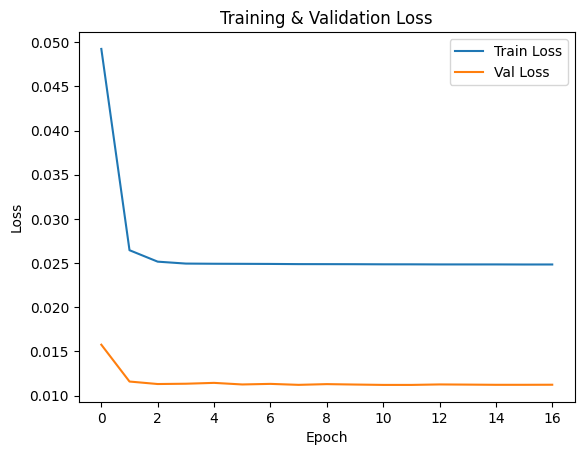

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_baseline_ffn.history['loss'], label='Train Loss')
plt.plot(history_baseline_ffn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# HPO & Search Strategy

We use Optuna to first create a broad search over a large hyperparameter space.

## Model Search Workflow

The probability that a trial is not in the 5th quantile is $P_{\text{fail}} = 1 - 0.05$, and the probability that $N$ trials all fail is $P_{\text{all fail}} = (1-0.05)^N$. The probability that at least one trial is in the 5th quantile is:
  
$$
1 - (1-0.05)^N |_{N=60} \approx 0.95383
$$

Thus, at least 60 trials are needed to ensure one is in the 5th quantile.

Using this, the model search workflow becomes:
1. 60 trail random search.
2. Sensitivity analysis using fANOVA to select HP's with cumulative importance $\geq 80\%$, and determine remaining HP vals.
3. Focused search on winners of 1 and 2. Random sample and median pruner with warmup.

## Phase 1 - Broad Search

First a broad search is executed using successive halving and random sampling.

In [9]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.9 MB/s eta 0:00:00


In [10]:
import joblib
import optuna

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
STORAGE_URI   = 'sqlite:///models studies/coarse_ffnn.db'
SEED          = 42
MAX_EPOCHS    = 20
N_TRAILS      = 60
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

Below we first define the function that creates a model for each trail.

In [11]:
def create_model(trial: optuna.Trial):

  # Hp sample
  n_layers                     = trial.suggest_int('n_layers', 1, 4, step=1)
  n_units                      = trial.suggest_int('n_units', 16, 256, step=16)
  act                          = trial.suggest_categorical('act', ['leaky_relu', 'relu'])
  bool_last_tanh               = trial.suggest_categorical('bool_last_tanh', [True, False])
  bool_dropout                 = trial.suggest_categorical('bool_dropout', [True, False])
  if bool_dropout: dropout_fac = trial.suggest_float('dropout', 0.01, 0.5)
  bool_l2_reg                  = trial.suggest_categorical('bool_l2_reg', [True, False])
  if bool_l2_reg: l2_reg_fac   = trial.suggest_float('c', 1e-6, 1e-2, log=True)
  l2_reg                       = l2(l2_reg_fac) if bool_l2_reg else None

  # Model
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  for i in range(n_layers):
    if i == n_layers-1 and bool_last_tanh:
      model.add(Dense(n_units, activation='tanh', kernel_regularizer=l2_reg))
    else:
      if act == 'relu':
        model.add(Dense(n_units, activation='relu', kernel_regularizer=l2_reg))
      else:
        negative_slope = trial.suggest_float('negative_slope', 1e-03, 0.3)
        model.add(Dense(n_units, kernel_regularizer=l2_reg))
        model.add(LeakyReLU(negative_slope=negative_slope))
    if bool_dropout:
      model.add(Dropout(dropout_fac))
  model.add(Dense(OUTPUT_SHAPE, activation='linear', kernel_regularizer=l2_reg))

  return model

We now define a function that retrives the objective function (i.e. the loss).

In [12]:
def objective(trial: optuna.Trial) -> float:

  # Hp sample
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  opt = trial.suggest_categorical('opt', ['adam', 'sgd'])
  if opt == 'sgd':
    mom = trial.suggest_float('mom', 0, 1)
    optimizer = tf.keras.optimizers.SGD(lr, mom)
  if opt == 'adam':
    beta1 = trial.suggest_float('beta1', 0.8, 0.95, log=True)
    beta2 = trial.suggest_float('beta2', 0.98, 0.9999, log=True)
    optimizer = tf.keras.optimizers.Adam(lr, beta1, beta2)

  # Retrive and compile model
  model = create_model(trial)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = EarlyStopping(
      monitor              = 'val_loss',
      patience             = 4,
      min_delta            = 1e-5,
      restore_best_weights = True
)

  # Create dataset
  train_ds = build_dataset(X_train, y_train, bs)
  val_ds   = build_dataset(X_val, y_val, bs)

  model.fit(
      train_ds,
      validation_data = val_ds,
      epochs          = MAX_EPOCHS,
      callbacks       = [earlystop_cb],
      verbose         = 0
      )

  return model.evaluate(val_ds, verbose=0)[0]

We now run the study.

In [ ]:
# Create random sampler
sampler = optuna.samplers.RandomSampler(seed = SEED)

# Create study
study_coarse = optuna.create_study(
    direction      = 'minimize',
    study_name     = 'coarse_ffnn_search',
    sampler        = sampler,
    storage        = STORAGE_URI,
    load_if_exists = True
    )

# Run study
study_coarse.optimize(objective, n_trials=N_TRAILS)

To load study instead of running again use code below.

In [13]:
study_coarse = optuna.load_study(
    study_name='coarse_ffnn_search',
    storage='sqlite:///models studies/coarse_ffnn.db'
)

## Phase 2 - fANOVA Importance & Base Params

The coarse study is now complete. We now evaluate what parameters to tune and what values to freeze. This evaluation is done by considering two factors:
1. **Feature importance**: using `fANOVA` each feature is given an importance measure.
2. **Frequency in top 20% models** (if a certain parameter is present in allmost all 20% of top performing models it can be fixed despite having large importance).

### Feature Importance

Now we find the most important parameters.

First we look at global parameters (params relevant in all trials).

In [ ]:
optuna.importance.get_param_importances(
    study_coarse,
    evaluator=optuna.importance.FanovaImportanceEvaluator(seed=SEED),
)

{'lr': np.float64(0.37026306440600587),
 'bs': np.float64(0.3699921770013502),
 'n_units': np.float64(0.06263891219937397),
 'opt': np.float64(0.06190465436075354),
 'bool_last_tanh': np.float64(0.03502501721478691),
 'bool_l2_reg': np.float64(0.034634706572225345),
 'bool_dropout': np.float64(0.026197219134202167),
 'n_layers': np.float64(0.02332560499940204),
 'act': np.float64(0.01601864411189997)}

Together **learning rate**, **batch size**, **number of units** and **optimizer**. These together account for $>85\%$ of parameter importance.

We keep tuning these values. For the remaining value we set reasonable defaults based on frequency in the top performing models. This is done below.

### Frequency in Top Models

Below we get the top 20% performing models.

In [130]:
# Get all trials and sort
study_df = study_coarse.trials_dataframe()
study_df = study_df.sort_values(by='value', ascending=True)

# Get best trials
top_performing_trials_df = study_df.head(int(0.2 * len(study_df)))
top_performing_trials_df.drop(columns=['number', 'datetime_start', 'datetime_complete', 'duration', 'state'])

,value,params_act,params_beta1,params_beta2,params_bool_dropout,params_bool_l2_reg,params_bool_last_tanh,params_bs,params_dropout,params_l2_reg,params_lr,params_mom,params_n_layers,params_n_units,params_negative_slope,params_opt
23,0.011130,leaky_relu,0.894423,0.994808,True,False,True,64,0.444421,NaN,0.000017,NaN,3,256,0.020285,adam
49,0.011137,leaky_relu,0.920921,0.995876,False,True,False,128,NaN,0.000147,0.005670,NaN,3,80,0.145343,adam
54,0.011137,leaky_relu,0.948559,0.984575,True,True,True,256,0.211101,0.007523,0.000741,NaN,4,176,0.154613,adam
56,0.011138,leaky_relu,0.811220,0.984347,True,True,False,32,0.141883,0.003270,0.000109,NaN,3,32,0.094476,adam
39,0.011139,leaky_relu,0.935171,0.991561,True,True,True,32,0.303188,0.000612,0.000102,NaN,2,128,0.192816,adam
19,0.011140,relu,NaN,NaN,True,False,False,64,0.208498,NaN,0.006123,0.735071,4,80,NaN,sgd
44,0.011141,relu,0.834140,0.994333,True,True,False,128,0.013973,0.000005,0.004083,NaN,4,224,NaN,adam
34,0.011142,relu,0.897415,0.998481,False,True,False,128,NaN,0.000277,0.018548,NaN,3,160,NaN,adam
8,0.011143,relu,0.812510,0.996595,True,False,True,32,0.124775,NaN,0.003382,NaN,2,48,NaN,adam
58,0.011145,relu,0.836527,0.992570,False,True,False,32,NaN,0.005609,0.002936,NaN,3,208,NaN,adam


From the table above we see that
- all but one trial uses the Adam optimizer,
- all but 2 trials have 3 or 4 layers,
- all but 3 trails use dropout,
- all but 4 trails use L2 regularization,
- 7 out of 12 trials use LeakyReLu activation,
- 50% of top performing models use $\tanh$ as the last activation function,


The following decisions are made keeping two things in mind (simplicity and importance).
- Optimizer choice is significant so we choose the `adam` optimizer going forward.
- `n_layers` is unimportant so we freeze this to 3 layers.
- All but 3 trials use dropout so we use dropout.
- All but 4 trials use L2 regularization so we use L2 regularization.
- Due to theoretical cleanliness and lack of importance, we choose to use last layer `tanh` (also 50% of top models use this).

We this have the following hyperparameter scheme for the final optimization:
- Optimizer: Adam (we use standard beta's)
- Layers: 3
- Dropout: True
- L2 regularization: True
- Activation: leakyReLu
- Last hidden layer: tanh


We thus have the following hyperparameters to tune:
- Learning rate.
- Batch size.
- Number of units.
- Dropout rate.
- L2 regularization factor.
- LeakyReLu negative slope.


## Phase 3 - Focused Search

We now create the final study for fine tuning. Below are the parameters and their state:

| Parameter             | State      | Value/Space |
|-----------------------|------------|-------------|
| Optimizer             | **Frozen** | Adam        |
| Number of layers      | **Frozen** | 3           |
| Dropout               | **Frozen** | True        |
| L2 regularization     | **Frozen** | True        |
| Activation            | **Frozen** | leakyReLU   |
| Last hidden tanh      | **Frozen** | True        |
| Learning rate         | **Tune**   |             |
| Batch size            | **Tune**   |             |
| Number of units       | **Tune**   |             |
| Dropout rate          | **Tune**   |             |
| L2 reg fac.           | **Tune**   |             |
| Leaky ReLu neg. slope | **Tune**   |             |

Since we do not need _large (n)_ amount of models to evaluate feature importance we can implement pruning.

However, pruning can introduce bias towards smaller batch sizes. Observed loss differences across epochs can stem from batch size-induced variance in gradient estimates, affecting convergence dynamics without reflecting the model's true explanatory power or generalization ability.

Several pruners exsist: Asyncronous Successive Halving, Percentile, Median, Hyperband, etc. We have opted for the median pruner primarily since it offers `n_startup_trials` and `n_warmup_steps` which ease batch size-induced variance in gradient estimated by letting models _warm up_ over _n_ epochs.

Below is the model creator.

In [11]:
STORAGE_URI   = 'sqlite:///models studies/fine_ffnn.db'
SEED          = 42
PATIENCE      = 6
MIN_DELTA     = 1e-04
MAX_EPOCHS    = 40
N_TRAILS      = 100
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

In [12]:
def create_model(trial: optuna.Trial):
  # Get HPs
  n_units        = trial.suggest_int('n_units', 16, 256)
  dropout        = trial.suggest_float('dropout', 1e-03, 0.5)
  l2_reg_fac     = trial.suggest_float('l2_reg_fac', 1e-06, 1e-02, log=True)
  negative_slope = trial.suggest_float('negative_slope', 1e-03, 0.3)

  # Get regulizer
  l2_reg = l2(l2_reg_fac)

  # Input layer
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))

  # 1'st hidden layer
  model.add(Dense(n_units, kernel_regularizer=l2_reg))
  model.add(LeakyReLU(negative_slope=negative_slope))
  model.add(Dropout(dropout))

  # 2'nd hidden layer
  model.add(Dense(n_units, kernel_regularizer=l2_reg))
  model.add(LeakyReLU(negative_slope=negative_slope))
  model.add(Dropout(dropout))

  # 3'nd hidden layer
  model.add(Dense(n_units, activation='tanh', kernel_regularizer=l2_reg))
  model.add(Dropout(dropout))

  # Output layer
  model.add(Dense(OUTPUT_SHAPE, activation='linear', kernel_regularizer=l2_reg))

  return model

In [13]:
def objective(trial: optuna.Trial):
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])

  # Retrieve and compile model
  model = create_model(trial)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss='mse',
      metrics=['mse', 'mae']
      )

  # Callbacks
  earlystop_cb = EarlyStopping(
      monitor              = 'val_loss',
      patience             = PATIENCE,
      min_delta            = MIN_DELTA,
      restore_best_weights = True
      )

  pruning_cb = optuna.integration.KerasPruningCallback(
      trial,
      monitor='val_loss'
      )

  # Create dataset
  train_ds = build_dataset(X_train, y_train, bs)
  val_ds = build_dataset(X_val, y_val, bs)

  # Fit model
  model.fit(
      train_ds,
      validation_data = val_ds,
      epochs          = MAX_EPOCHS,
      callbacks       = [pruning_cb, earlystop_cb],
      verbose         = 0
  )

  return model.evaluate(val_ds, verbose=0)[0]

In [ ]:
# Create random sampler and median pruner
sampler = optuna.samplers.RandomSampler(seed = SEED)
pruner  = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=4,
    interval_steps=1,
    n_min_trials=10
)

# Create study
study_coarse = optuna.create_study(
    direction      = 'minimize',
    study_name     = 'fine_ffnn_search',
    sampler        = sampler,
    pruner         = pruner,
    storage        = STORAGE_URI,
    load_if_exists = True
    )

# Run study
study_coarse.optimize(objective, n_trials=N_TRAILS)

In [30]:
study_coarse = optuna.load_study(
    study_name='coarse_ffnn_search',
    storage='sqlite:///models studies/fine_ffnn.db'
)

In [25]:
study_coarse = optuna.load_study(
    study_name='coarse_ffnn_search',
    storage='sqlite:///models studies/coarse_ffnn.db'
)

In [31]:
# Get all trials and sort
study_df = study_coarse.trials_dataframe()
study_df = study_df.sort_values(by='value', ascending=True)

# Get best trials
top_performing_trials_df = study_df.head(int(0.2 * len(study_df)))
top_performing_trials_df.drop(columns=['number', 'datetime_start', 'datetime_complete', 'duration', 'state'])

,value,params_bs,params_dropout,params_l2_reg_fac,params_lr,params_n_units,params_negative_slope
3,0.011162,128,0.474494,0.007287,0.000349,31,0.242711
82,0.011170,256,0.116874,0.003966,0.000208,137,0.115783
88,0.011179,256,0.348629,0.004898,0.000329,152,0.212464
59,0.011185,32,0.124427,0.000063,0.009981,220,0.039619
52,0.011195,128,0.264323,0.009373,0.000047,230,0.023065
0,0.011210,32,0.029984,0.002915,0.000133,53,0.180733
39,0.011211,32,0.293302,0.005767,0.003711,22,0.173067
78,0.011216,128,0.128066,0.000532,0.000102,211,0.228308
36,0.011218,32,0.178630,0.001075,0.007321,75,0.005304
58,0.011221,32,0.029131,0.002877,0.008124,81,0.244057
